In [1]:
import sys, os, os.path
base = os.path.realpath("../../..")
heap = base + "/crsq-heap/src"
if (heap) not in sys.path:
    sys.path.append(heap)
    sys.path.append(base + "/crsq-arithmetic/src")
    sys.path.append(base + "/crsq-main/src")
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/hideo-t/work/py/crsq/crsq-papers/2023/.2023/lib/python3.10/site-packages', '/home/hideo-t/work/py/crsq/crsq-heap/src', '/home/hideo-t/work/py/crsq/crsq-arithmetic/src', '/home/hideo-t/work/py/crsq/crsq-main/src']


# This notebook may take several hours to run.

# Qubit size evaluation for different model sizes

In [2]:
import math
import logging
from io import TextIOWrapper
import os

from qiskit import transpile
from qiskit_aer import Aer
import crsq.top.firstq as firstq
from crsq.blocks import time_evolution

logging.basicConfig()
logging.getLogger('crsq').setLevel(logging.INFO)

logger=logging.getLogger(__name__)

# do_heavy_calculation = False
do_heavy_calculation = True

def write_header(f: TextIOWrapper):
    f.write("dim,m,Ne,Na,Nsa,qubits,depth_e,depth_a\n")

def write_line(f: TextIOWrapper, dim, m, Ne, Na, Nsa, qubits, dep_e, dep_a):
    cols = [dim, m, Ne, Na, Nsa, qubits, dep_e, dep_a]
    colstrs = [str(col) for col in cols]
    f.write(",".join(colstrs) + "\n")
    f.flush()

def eval_model_size(
        f1: TextIOWrapper,
        f2: TextIOWrapper,
        d: int,
        m: int,
        Ne: int,
        Na: int,  # nucleus, treated quantum mechanically
        Nsa: int,  # nucleus treated as stationary
        nc: int,
        evaluate_depth: bool=False
        ) -> int:
    """ m: bits per coordinate
    """
    if Nsa < 0:
        # Kassal's model
        n = m*(3*(Ne+Na)-6)+4*m
        dep_elec = 0
        dep_nucl = 0
    else:
        M = 2**m
        L=2
        delta_t = 0.1
        t = firstq.FirstQIntegrator()
        t.set_dimension(d)
        t.set_space_length(L)
        t.set_coordinate_bits(m)
        t.set_num_particles(Ne,Na,Nsa)
        t.set_num_energy_configurations(nc)
        weights = list(range(nc))
        t.set_energy_configuration_weights(weights)
        t.set_max_particle_charge(1)
        t.set_initialize_energy(False)
        t.set_use_motion_block_gates(True)
        t.set_num_atom_iterations(1)
        t.set_num_elec_per_atom_iterations(1)
        t.set_delta_t(delta_t)
        logger.info(" make dummy orbitals")
        t.make_dummy_orbitals()
        logger.info(" make dummy nuclei data")
        t.make_dummy_nuclei_data()
        logger.info(" calculate sizes")
        t.calculate_sizes()
        logger.info(" allocate registers")
        t.allocate_registers()
        logger.info(" build circuit")
        t.build_circuit()
        n = len(t.circuit().qubits)
        logger.info(f"d: {d}, m: {m}, Ne: {Ne}, Na: {Na}, Nsa: {Nsa}, qubits: {n}")
        if evaluate_depth:
            backend = AerSimulator()
            backend = Aer.get_backend('')

            logger.info("  get_electron_motion_block")
            elec_motion_block = t.build_electron_motion_block()
            logger.info("  transpile")
            decomposed_elec = transpile(elec_motion_block.circuit, backend)
            dep_elec = decomposed_elec.depth()

            logger.info("  get_nucleus_motion_block")
            nucl_motion_block = t.build_nucleus_motion_block()
            logger.info("  transpile")
            decomposed_nucl = transpile(nucl_motion_block.circuit, backend)
            dep_nucl = decomposed_nucl.depth()
        else:
            dep_elec = 0
            dep_nucl = 0

    write_line(f1, d, m, Ne, Na, Nsa, n, dep_elec, dep_nucl)
    write_line(f2, d, m, Ne, Na, Nsa, n, dep_elec, dep_nucl)


dirname="output/circuit-sizes"
if do_heavy_calculation:
    fname1 = f"{dirname}/circuit-sizes.csv"
    with open(fname1, "a") as f1:
        for Ne,Na,Nsa in [
            (1,1,0), (2,1,0), (3,1,0), (3,3,0), (8,1,0),
            (1,0,1), (2,0,1), (3,0,1), (3,0,3), (8,0,1),
            (30, 0, 7), (30, 7, 0),
            (38, 0, 10), (38, 10, 0),
            (1,1,-1), (2,1,-1), (3,1,-1), (3,3,-1), (8,1,-1),
            (30, 7, -1), 
            (38, 10, -1),
        ]:
        # for Ne, Na, Nsa in [(1,0,1), (3,0,3)]:
        # for Ne,Na,Nsa in [(30, 0, 7)]:
            fname2 = f"{dirname}/Ne{Ne}Na{Na}Nsa{Nsa}.csv"
            logfile = f"{dirname}/Ne{Ne}Na{Na}Nsa{Nsa}.log"
            logging.basicConfig(filename=logfile, force=True)
            logging.getLogger('crsq').setLevel(logging.INFO)
            print("logfile : ", logfile)
            if not os.path.exists(fname2):
                with open(fname2, "a") as f2:
                    write_header(f2)
            # for m in [10, 20, 30]:
            for m in [10]:
                with open(fname2, "a") as f2:
                    for d in [3]:
                        logger.info(f"Ne: {Ne}, Na: {Na}, Nsa: {Nsa}, m: {m}")
                        eval_model_size(f1, f2, d=d, m=m, Ne=Ne, Na=Na, Nsa=Nsa, nc=1)
                        logger.info(f"Ne: {Ne}, Na: {Na}, Nsa: {Nsa}, m: {m}: done")


logfile :  output/circuit-sizes/Ne1Na1Nsa0.log
logfile :  output/circuit-sizes/Ne2Na1Nsa0.log
logfile :  output/circuit-sizes/Ne3Na1Nsa0.log
logfile :  output/circuit-sizes/Ne3Na3Nsa0.log
logfile :  output/circuit-sizes/Ne8Na1Nsa0.log
logfile :  output/circuit-sizes/Ne1Na0Nsa1.log
logfile :  output/circuit-sizes/Ne2Na0Nsa1.log
logfile :  output/circuit-sizes/Ne3Na0Nsa1.log
logfile :  output/circuit-sizes/Ne3Na0Nsa3.log
logfile :  output/circuit-sizes/Ne8Na0Nsa1.log
logfile :  output/circuit-sizes/Ne30Na0Nsa7.log
logfile :  output/circuit-sizes/Ne30Na7Nsa0.log
logfile :  output/circuit-sizes/Ne38Na0Nsa10.log
logfile :  output/circuit-sizes/Ne38Na10Nsa0.log
logfile :  output/circuit-sizes/Ne1Na1Nsa-1.log
logfile :  output/circuit-sizes/Ne2Na1Nsa-1.log
logfile :  output/circuit-sizes/Ne3Na1Nsa-1.log
logfile :  output/circuit-sizes/Ne3Na3Nsa-1.log
logfile :  output/circuit-sizes/Ne8Na1Nsa-1.log
logfile :  output/circuit-sizes/Ne30Na7Nsa-1.log
logfile :  output/circuit-sizes/Ne38Na10Nsa-1.l

dim:3 res:10 Ne:1 Na:1 Nas:0
dim:3 res:10 Ne:2 Na:1 Nas:0
dim:3 res:10 Ne:3 Na:1 Nas:0
dim:3 res:10 Ne:3 Na:3 Nas:0
dim:3 res:10 Ne:8 Na:1 Nas:0
dim:3 res:10 Ne:1 Na:0 Nas:1
dim:3 res:10 Ne:2 Na:0 Nas:1
dim:3 res:10 Ne:3 Na:0 Nas:1
dim:3 res:10 Ne:3 Na:0 Nas:3
dim:3 res:10 Ne:8 Na:0 Nas:1
dim:3 res:10 Ne:1 Na:1 Nas:-1
dim:3 res:10 Ne:2 Na:1 Nas:-1
dim:3 res:10 Ne:3 Na:1 Nas:-1
dim:3 res:10 Ne:3 Na:3 Nas:-1
dim:3 res:10 Ne:8 Na:1 Nas:-1
dim:3 res:10 Ne:30 Na:0 Nas:7
dim:3 res:10 Ne:30 Na:7 Nas:0
dim:3 res:10 Ne:30 Na:7 Nas:-1
dim:3 res:10 Ne:38 Na:0 Nas:10
dim:3 res:10 Ne:38 Na:10 Nas:0
dim:3 res:10 Ne:38 Na:10 Nas:-1


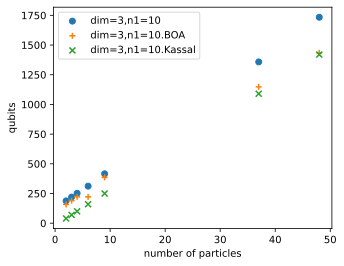

In [2]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import numpy as np
dpi=300
data = {}
dirname="output/circuit-sizes"

with open(f"{dirname}/circuit-sizes.csv") as f:
    # header = f.readline()
    for line in f:
        colstrs = line.split(',')
        # print(f"columns: {colstrs}")
        cols = [int(s) for s in colstrs]
        d = cols[0]
        m = cols[1]
        Ne = cols[2]
        Na = cols[3]
        Nas = cols[4]
        rec = {
            'qubits': cols[5],
            'depth_e': cols[6],
            'depth_a': cols[7]
        }
        if not d in data:
            data[d] = {}
        if not m in data[d]:
            data[d][m] = {}
        if not Ne in data[d][m]:
            data[d][m][Ne] = {}
        if not Na in data[d][m][Ne]:
            data[d][m][Ne][Na] = {}
        data[d][m][Ne][Na][Nas] = rec

NN = [
    (1,1,0), (2,1,0), (3,1,0), (3,3,0), (8,1,0),
    (1,0,1), (2,0,1), (3,0,1), (3,0,3), (8,0,1),
    (1,1,-1), (2,1,-1), (3,1,-1), (3,3,-1), (8,1,-1),
    (30, 0, 7), (30, 7, 0), (30, 7, -1), 
    (38, 0, 10), (38, 10, 0), (38, 10, -1),
]
x = []
xboa = []
xkas = []
y310q = []
y310d = []
yq = {}
yd = {}
for Ne, Na, Nas in NN:
    if Nas > 0:
        boa = 1
        xboa.append(Ne+Na+Nas)
    elif Nas < 0:
        boa = 2
        xkas.append(Ne+Na)
    else:
        boa = 0
        x.append(Ne+Na+Nas)
    for dim in [3]:
        if dim not in yq:
            yq[dim] = {}
            yd[dim] = {}
        for res in [10]:
            print(f"dim:{dim} res:{res} Ne:{Ne} Na:{Na} Nas:{Nas}")
            if res not in yq[dim]:
                yq[dim][res] = [[],[],[]]
                yd[dim][res] = [[],[],[]]
            rec = data[dim][res][Ne][Na][Nas]
            yq[dim][res][boa].append(rec['qubits'])
            yd[dim][res][boa].append((rec['depth_e'] + rec['depth_a'])/1000)

fig, ax0 = plt.subplots(figsize=(5.0, 4.0), dpi=dpi)

ax0.set_xlabel('number of particles')
ax0.set_ylabel('qubits')

# ax1.set_ylabel('kilo-depth per time step')

xnp = np.array(x)
xboanp = np.array(xboa)
xkasnp = np.array(xkas)
#ynpq = {1: {}, 3: {}}
#ynpd = {1: {}, 3: {}}
for dim in [3]:
    for res in [10]:
        for boa in [0,1,2]:
            ynpq = np.array(yq[dim][res][boa])
            ynpd = np.array(yd[dim][res][boa])
            if boa == 2:
                ax0.scatter(xkasnp, ynpq, marker="x", label=f"dim={dim},n1={res}.Kassal")
                # ax1.scatter(xboanp,ynpd, label=f"dim={dim},m={res}.BOA")
            elif boa == 1:
                ax0.scatter(xboanp, ynpq, marker="+", label=f"dim={dim},n1={res}.BOA")
                # ax1.scatter(xboanp,ynpd, label=f"dim={dim},m={res}.BOA")
            else:
                ax0.scatter(xnp, ynpq, marker="o", label=f"dim={dim},n1={res}")
                # ax1.scatter(xnp,ynpd, label=f"dim={dim},m={res}")

ax0.legend()
# ax1.legend()

plt.savefig('paper_diagrams/circuit-size-qubits.png')
plt.show()